In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.4 MB/s eta 0:00:00


In [ ]:
!pip install PyWavelets
import mne, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.io
from scipy.signal import savgol_filter
import pywt
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import scipy.io
from mne.preprocessing import ICA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import welch
from sklearn.metrics import classification_report
from scipy.signal import spectrogram

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.7 MB/s eta 0:00:00


**Filtering, Artifact Removal, and ICA for Enhanced Signal Quality**

In [ ]:
def process_data(data_path, sfreq, ch_names, ch_types, excluded_components):
    data = scipy.io.loadmat(data_path)
    try:
        np_arr = np.array(data['Data'])
    except KeyError:
        print("Key 'Data' not found in the.mat file.")
        return None

    info = mne.create_info(ch_names, sfreq, ch_types)
    raw = mne.io.RawArray(np_arr, info)
    raw.filter(0.5, 45)

    sg_filter = savgol_filter(raw.get_data(), 127, 5, axis=1)
    raw_data = raw.get_data() - sg_filter
    coeffs = pywt.wavedec(raw_data, 'db2', level=4, axis=1)
    raw_data = pywt.waverec(coeffs, 'db2', axis=1)

    ica = mne.preprocessing.ICA(n_components=20, random_state=0)
    ica.fit(raw)
    raw = ica.apply(raw)
    ica.plot_sources(raw)
    raw = ica.apply(raw, exclude=excluded_components)
    ica.plot_sources(raw)

    return raw

**Time-Domain and Frequency-Domain Analysis with PSD Computation**

In [ ]:
def extract_features(raw, sfreq, win_length_sec, overlap_sec):
    win_length_samples = int(win_length_sec * sfreq)
    overlap_samples = int(overlap_sec * sfreq)
    features_list = []
    for start in range(0, raw.get_data().shape[1] - win_length_samples + 1, overlap_samples):
        window = raw.get_data()[:, start:start+win_length_samples]
        mean_time = np.mean(window, axis=1)
        std_time = np.std(window, axis=1)
        psd, freqs = mne.time_frequency.psd_array_welch(window, sfreq, fmin=0.5, fmax=45., n_fft=sfreq)
        freq_res = freqs[1] - freqs[0]
        alpha_band = psd[:, (freqs>=8) & (freqs<=12)].mean(axis=1) * freq_res
        beta_band = psd[:, (freqs>=12) & (freqs<=30)].mean(axis=1) * freq_res
        features_list.append(np.column_stack([mean_time, std_time, alpha_band, beta_band]))
    features = np.concatenate(features_list)
    return features

**Logistic Regression with Train-Test Evaluation**

In [ ]:
def classify_data(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Training accuracy: ", model.score(X_train, y_train))
    print("Testing accuracy: ", model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    print(len(X_test))

**From Preprocessing to Classification(without Leave-One-Patient-Out (LOPO) cross-validation)**

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 5.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


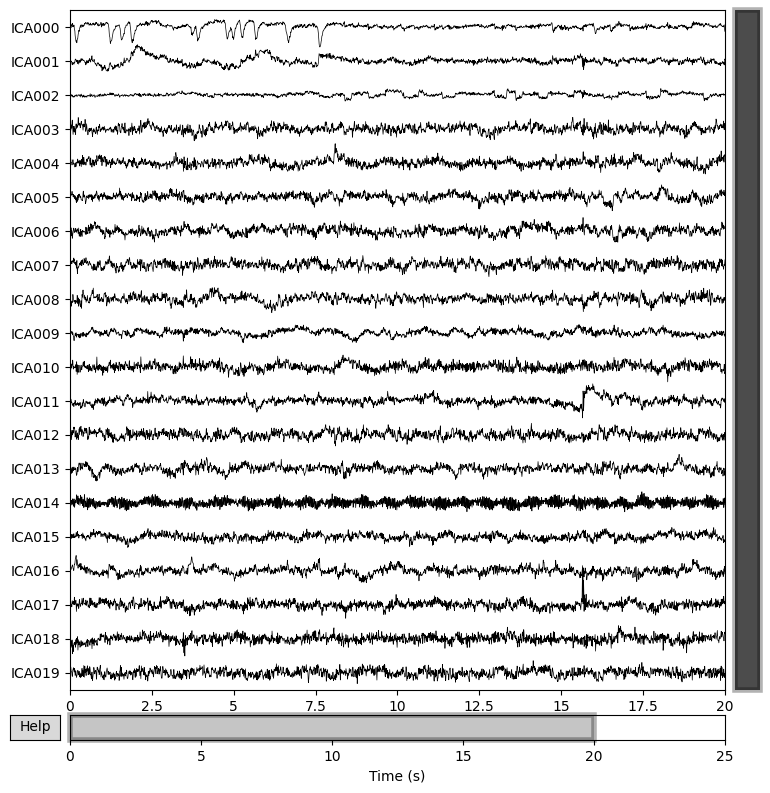

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


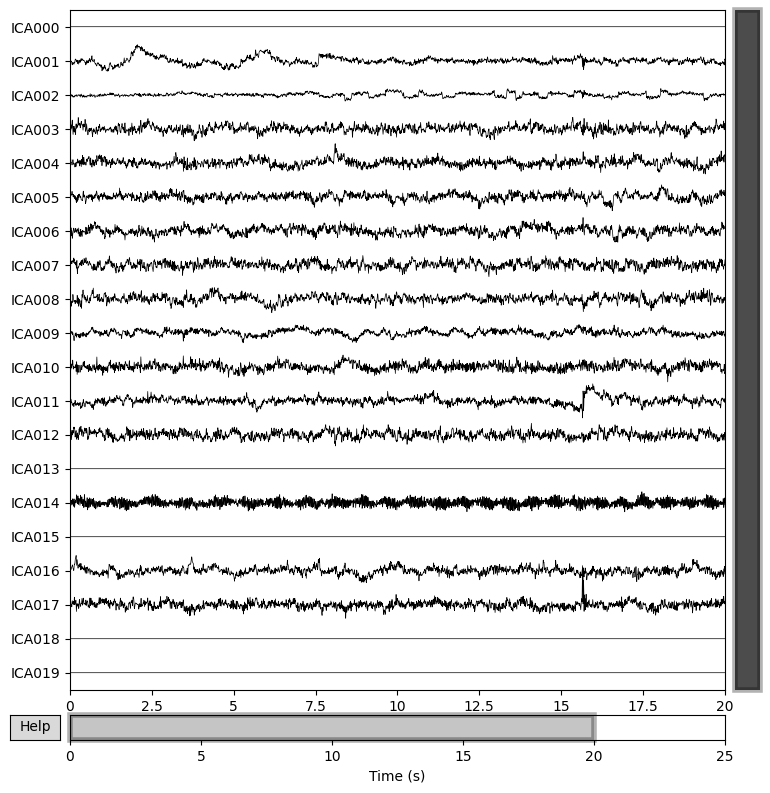

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 7.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


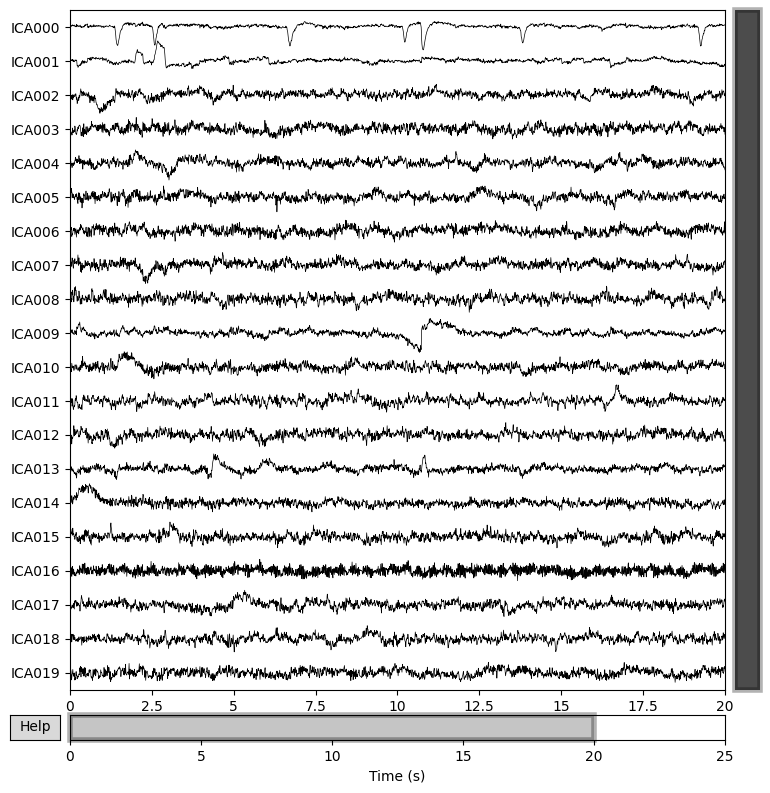

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


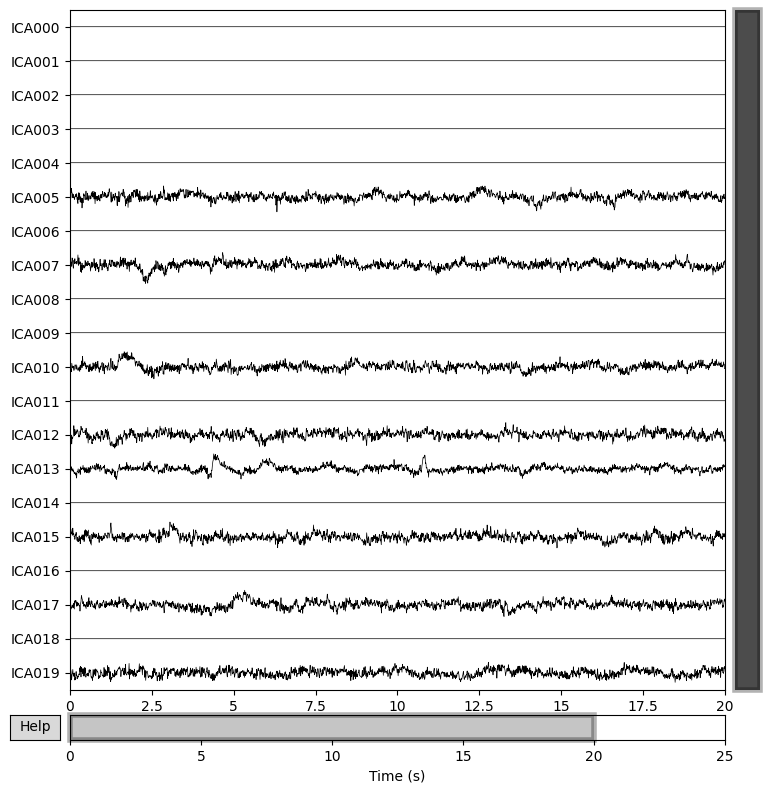

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

In [ ]:
sfreq = 128
ch_names = ['CZ', 'FZ', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'PZ', 'OZ', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
ch_types = ['eeg'] * 32

excluded_components1 = [0,13,15,18,19]
excluded_components2 = [0,1,2,3,4,6,8,9,11,14,16,18]

raw1 = process_data('/content/Mirror_image_sub_6_trial2.mat', sfreq, ch_names, ch_types, excluded_components1)
raw2 = process_data('/content/Relax_sub_6_trial2.mat', sfreq, ch_names, ch_types, excluded_components2)

features1 = extract_features(raw1, sfreq, win_length_sec=1, overlap_sec=0.5)
features2 = extract_features(raw2, sfreq, win_length_sec=1, overlap_sec=0.5)

features = np.concatenate([features1, features2])
labels1 = np.ones(features1.shape[0])
labels2 = np.zeros(features2.shape[0])
labels = np.concatenate([labels1, labels2])

classify_data(features, labels)